## <font color="Greenyellow">Trabajo de Fin Master 3: Optimizacion de hiperparametros</font>
<a id="item0"></a> 

### <font color="Greenyellow">0. Indice</font>

* [1. Inicializacion del notebook](#item1)
* [2. ETL](#item2)
* [3. Modelos base](#item3)


***
<a id="item1"></a>
### <font color="Greenyellow">1. Inicializacion del notebook</font>

#### <font color="Greenyellow">1.1. Importacion de librerias</font>

In [12]:
# Analisis y transformacion de datos
import pandas as pd
import numpy as np
# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# Base de datos
import sqlite3
# Funciones propias en carpeta 'funciones
import funciones.funciones as funciones
# funciones machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import  StratifiedKFold
# Optimizadores
from skopt import BayesSearchCV
from skopt.space import Real, Integer
# Modelos
import joblib

#### <font color="Greenyellow">1.2. Parametros del notebook</font>

In [2]:
carpeta_base_datos = 'bbdd'
nombre_bbdd        = 'base_datos_tfm.db'
semilla = 12345
pct_test=0.20

***
<a id="item2"></a>
### <font color="Greenyellow">2. ETL</font>
[Volver al indice](#item0)

In [3]:
# importamos los datos
df = funciones.query_bbdd(carpeta_base_datos, nombre_bbdd='base_datos_tfm.db', query='SELECT * FROM meta_df')

In [4]:
# transformamos los datos y dividimos en train y test
X_train, X_test, y_train, y_test = funciones.preparar_datos(df, n_columnas_x=31, pct_test=pct_test, semilla=semilla)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (227845, 31), y_train shape: (227845,)
X_test shape: (56962, 31), y_test shape: (56962,)


***
<a id="item3"></a>
### <font color="Greenyellow">3. Bagging de regresión logistica</font>
[Volver al indice](#item0)

#### <font color="Greenyellow">3.1. Modelo sin optimizar</font>

1. Entrenando el modelo...
... entrenamiento completado.
    A. Precisión del modelo: 0.9798
    B. F1 Score: 0.1219
    C. AUC: 0.9839
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8889
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56872
           1       0.07      0.89      0.12        90

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.56     56962
weighted avg       1.00      0.98      0.99     56962



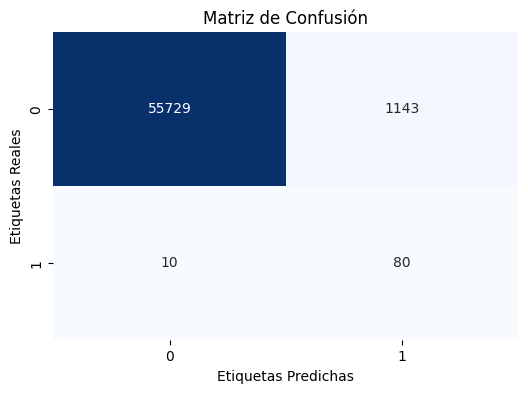


   Puntuaciones F1 de CV (k=5): [0.13546566 0.14401623 0.13543599 0.15659955 0.14299153]
   Promedio de F1 de CV: 0.1429


In [5]:
# 1. Instanciamos el modelo base (Regresión Logística)
base_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=semilla, n_jobs=-1)
# 2. Instanciamos el BaggingClassifier
model = BaggingClassifier(estimator=base_model,
                          n_estimators=50,
                          random_state=semilla,
                          n_jobs=-1)
# 3. Implementamos validación cruzada (CV) al modelo (5 pliegues)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
# 4. Entrenamos el modelo de ensamble
print("1. Entrenando el modelo...")
model.fit(X_train, y_train)
print("... entrenamiento completado.")
# 5. Evaluamos el modelo
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(model, X_test, y_test)
print(f"\n   Puntuaciones F1 de CV (k=5): {cv_scores}")
print(f"   Promedio de F1 de CV: {np.mean(cv_scores):.4f}")

#### <font color="Greenyellow">3.2. Optimizacion de hiperparametros</font>

In [6]:
# Instanciamos el modelo a optimizar
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=semilla, n_jobs=-1)

In [7]:
%%time
# Define el espacio de búsqueda
espacio_busqueda = {
    "C": Real(0.01, 10.0, prior='log-uniform'),
    "penalty": ['l1', 'l2'],
    "max_iter": Integer(20, 50),
    "class_weight": ['balanced', None]
    }
# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=semilla)
# Búsqueda Bayesiana
opt = BayesSearchCV(
    estimator=model,
    search_spaces=espacio_busqueda,
    scoring="average_precision",
    cv=cv,
    n_iter=5,
    n_jobs=-1,
    verbose=0,
    random_state=semilla
)
# Entrenamiento del optimizador
opt.fit(X_train, y_train)
# Mejor resultado
print("Mejores parámetros encontrados:")
print(opt.best_params_)
print(f"Mejor puntuación average_precision (AUC-PR): {opt.best_score_:.4f}")

c:\Users\Nitropc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Mejores parámetros encontrados:
OrderedDict([('C', 7.858320265314798), ('class_weight', None), ('max_iter', 21), ('penalty', 'l1')])
Mejor puntuación average_precision (AUC-PR): 0.7952
CPU times: total: 3.84 s
Wall time: 23.2 s


c:\Users\Nitropc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [8]:
# Guardamos los mejores parametros con joblib
joblib.dump(opt.best_params_, 'data/parametros/r_logistica_best_params.pkl')

['data/parametros/r_logistica_best_params.pkl']

#### <font color="Greenyellow">3.3. Modelo optimizado</font>

In [9]:
# Cargamos los mejores parametros
best_params_rl = ""
best_params_rl = joblib.load('data/parametros/r_logistica_best_params.pkl')
best_params_rl

OrderedDict([('C', 7.858320265314798),
             ('class_weight', None),
             ('max_iter', 21),
             ('penalty', 'l1')])

1. Entrenando el modelo...
... entrenamiento completado.
    A. Precisión del modelo: 0.9995
    B. F1 Score: 0.8242
    C. AUC: 0.9647
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.7556
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.91      0.76      0.82        90

    accuracy                           1.00     56962
   macro avg       0.95      0.88      0.91     56962
weighted avg       1.00      1.00      1.00     56962



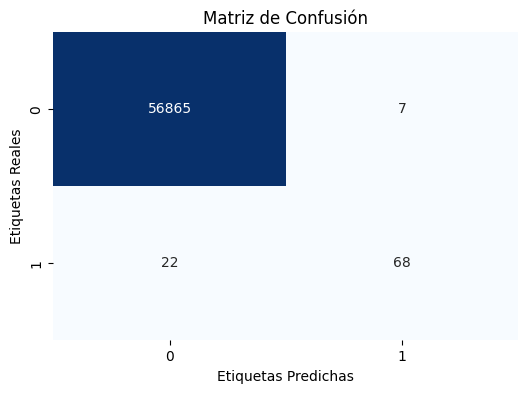


   Puntuaciones F1 de CV (k=5): [0.71532847 0.8028169  0.76258993 0.75524476 0.88      ]
   Promedio de F1 de CV: 0.7832
CPU times: total: 453 ms
Wall time: 1min 30s


In [10]:
%%time
# 1. Instanciamos el modelo base (Regresión Logística)
base_model = LogisticRegression(**best_params_rl, solver='liblinear', random_state=semilla)
# 2. Instanciamos el BaggingClassifier
model = BaggingClassifier(estimator=base_model,
                          n_estimators=10,
                          random_state=semilla,
                          n_jobs=-1)
# 3. Implementamos validación cruzada (CV) al modelo (5 pliegues)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
# 4. Entrenamos el modelo de ensamble
print("1. Entrenando el modelo...")
model.fit(X_train, y_train)
print("... entrenamiento completado.")
# 5. Evaluamos el modelo
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(model, X_test, y_test)
print(f"\n   Puntuaciones F1 de CV (k=5): {cv_scores}")
print(f"   Promedio de F1 de CV: {np.mean(cv_scores):.4f}")

In [13]:
f2_rlog = fbeta_score(y_test, model.predict(X_test), beta=2, pos_label=1)
print(f'F2 score Regresion Logistica: {f2_rlog:.4f}')

F2 score Regresion Logistica: 0.7816


In [14]:
# guardamos el f1 y recall_minoritaria en la carpeta de data mediante joblib
joblib.dump(f1, 'data/metricas/f1_rlog.pkl')
joblib.dump(recall_minoritaria, 'data/metricas/recall_rlog.pkl')
joblib.dump(f2_rlog, 'data/metricas/f2_rlog.pkl')

['data/metricas/f2_rlog.pkl']

***
[Volver al indice](#item0)